In [1]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt


In [2]:
dataset = pd.read_csv("../data/ada.csv")

In [3]:
dataset

,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,2017-12-29,0.517300,1.080000,0.400004,1.000000,4.262042e+06,0.517300,1.080000,0.400004,1.000000,4.262042e+06,0.0,1.0
1,2017-12-30,0.590030,0.694139,0.420000,0.520000,2.496892e+07,0.590030,0.694139,0.420000,0.520000,2.496892e+07,0.0,1.0
2,2017-12-31,0.710000,0.740000,0.590020,0.590030,1.324840e+07,0.710000,0.740000,0.590020,0.590030,1.324840e+07,0.0,1.0
3,2018-01-01,0.702160,0.715000,0.632000,0.703400,1.380754e+07,0.702160,0.715000,0.632000,0.703400,1.380754e+07,0.0,1.0
4,2018-01-02,0.762000,0.800000,0.675020,0.704000,8.440669e+06,0.762000,0.800000,0.675020,0.704000,8.440669e+06,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1180,2021-04-27,1.306639,1.333633,1.223582,1.237973,4.791092e+08,1.306639,1.333633,1.223582,1.237973,4.791092e+08,0.0,1.0
1181,2021-04-28,1.337979,1.349051,1.233085,1.306617,4.717582e+08,1.337979,1.349051,1.233085,1.306617,4.717582e+08,0.0,1.0
1182,2021-04-29,1.306542,1.411739,1.266448,1.337613,6.828781e+08,1.306542,1.411739,1.266448,1.337613,6.828781e+08,0.0,1.0
1183,2021-04-30,1.353140,1.370994,1.285897,1.306601,3.870279e+08,1.353140,1.370994,1.285897,1.306601,3.870279e+08,0.0,1.0


In [4]:
data = copy.deepcopy(dataset)
data = data.drop(columns=['date', 'volume', 'adjClose', 'adjHigh','adjLow','adjOpen', 'adjVolume', 'divCash', 'splitFactor'], axis=1)


In [5]:
data

,close,high,low,open
0,0.517300,1.080000,0.400004,1.000000
1,0.590030,0.694139,0.420000,0.520000
2,0.710000,0.740000,0.590020,0.590030
3,0.702160,0.715000,0.632000,0.703400
4,0.762000,0.800000,0.675020,0.704000
...,...,...,...,...
1180,1.306639,1.333633,1.223582,1.237973
1181,1.337979,1.349051,1.233085,1.306617
1182,1.306542,1.411739,1.266448,1.337613
1183,1.353140,1.370994,1.285897,1.306601


In [6]:
if data.isnull().sum().sum() >0:
    data = data.fillna(method='pad') # filling null values with their previous
    print ('filled empty values')
else:
    print ('No empty values')

No empty values


# Feature Engineering


In [7]:
tek_ind_1 = copy.deepcopy(data)
tek_ind_2 = copy.deepcopy(data)

In [8]:
tek_ind_1

,close,high,low,open
0,0.517300,1.080000,0.400004,1.000000
1,0.590030,0.694139,0.420000,0.520000
2,0.710000,0.740000,0.590020,0.590030
3,0.702160,0.715000,0.632000,0.703400
4,0.762000,0.800000,0.675020,0.704000
...,...,...,...,...
1180,1.306639,1.333633,1.223582,1.237973
1181,1.337979,1.349051,1.233085,1.306617
1182,1.306542,1.411739,1.266448,1.337613
1183,1.353140,1.370994,1.285897,1.306601


In [9]:
tek_ind_1['daily_return'] = tek_ind_1.close.pct_change().fillna(0) # Percentage change between the current and a prior element
tek_ind_1['cum_daily_return'] = (1 + tek_ind_1['daily_return']).cumprod() # Cummulative Product (+1 is used not so we can ignore the 0s in the first couple rows)

tek_ind_1['H-L'] = tek_ind_1.high - dataset.low

tek_ind_1['C-O'] = tek_ind_1.close - tek_ind_1.open

tek_ind_1['10day Ma'] = tek_ind_1.close.shift(1).rolling(window = 10).mean().fillna(0)
tek_ind_1['50day Ma'] = tek_ind_1.close.shift(1).rolling(window = 50).mean().fillna(0)
tek_ind_1['200day Ma'] = tek_ind_1.close.shift(1).rolling(window = 200).mean().fillna(0)

import talib
tek_ind_1['rsi'] = talib.RSI(tek_ind_1.close.values, timeperiod = 14)

tek_ind_1['williams %R'] = talib.WILLR(tek_ind_1.high.values,
                                       tek_ind_1.low.values, 
                                      tek_ind_1.close.values, 
                                      14)

# create 7 and 21 days Moving Average
tek_ind_1['ma7'] = tek_ind_1.close.rolling(window=7).mean().fillna(0)
tek_ind_1['ma21'] = tek_ind_1.close.rolling(window=21).mean().fillna(0)

# creating MACD
tek_ind_1['ema_26'] = tek_ind_1.close.ewm(span=26).mean().fillna(0)
tek_ind_1['ema_12'] = tek_ind_1.close.ewm(span=12).mean().fillna(0)
tek_ind_1['macd'] = (tek_ind_1['ema_12'] - tek_ind_1['ema_26'])

In [10]:
# creating bollinger Bands
#Set number of days and standard deviation to use for rolling lookback period for bollinger band calculation
window = 21
no_of_std =2

#calculate rolling mean and standard deviation using number of days set above
rolling_mean = tek_ind_1.close.rolling(window).mean()
rolling_std = tek_ind_1.close.rolling(window).std()

#create two new DF column to hold values of upper and lower Bollinger bands
tek_ind_1['bb_high'] =(rolling_mean + (rolling_std * no_of_std)).fillna(0)
tek_ind_1['bb_low'] =(rolling_mean - (rolling_std * no_of_std)).fillna(0)

#create exponental moving average
tek_ind_1['ema'] = tek_ind_1.close.ewm(com=0.5).mean()

#create momentum
tek_ind_1['momentum'] = tek_ind_1.close - 1

# tek_ind_1.head(20)

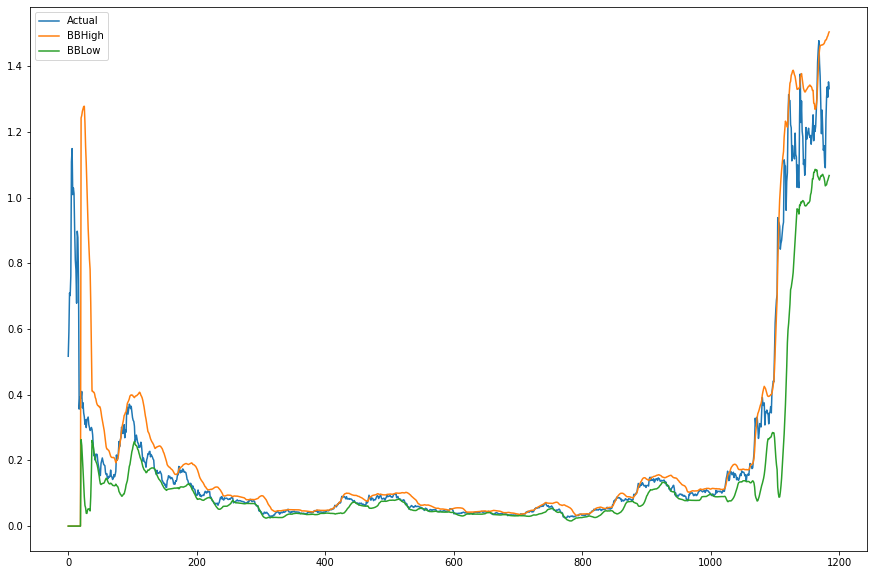

In [11]:
plt.figure(figsize=(15, 10))
plt.plot(tek_ind_1['close'], label ='Actual')
plt.plot(tek_ind_1['bb_high'], label ='BBHigh')
plt.plot(tek_ind_1['bb_low'], label ='BBLow')
plt.legend(loc='best')

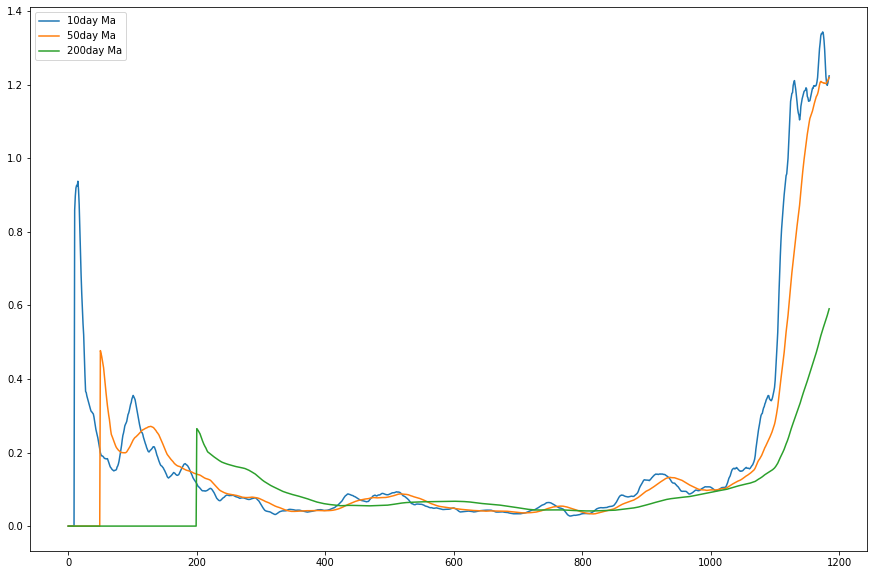

In [12]:
plt.figure(figsize=(15, 10))
plt.plot(tek_ind_1['10day Ma'], label ='10day Ma')
plt.plot(tek_ind_1['50day Ma'], label ='50day Ma')
plt.plot(tek_ind_1['200day Ma'], label ='200day Ma')
plt.legend(loc='best')

In [13]:
tek_ind_1_copy = copy.deepcopy(tek_ind_1)

tek_ind_1_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1185 entries, 0 to 1184
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   close             1185 non-null   float64
 1   high              1185 non-null   float64
 2   low               1185 non-null   float64
 3   open              1185 non-null   float64
 4   daily_return      1185 non-null   float64
 5   cum_daily_return  1185 non-null   float64
 6   H-L               1185 non-null   float64
 7   C-O               1185 non-null   float64
 8   10day Ma          1185 non-null   float64
 9   50day Ma          1185 non-null   float64
 10  200day Ma         1185 non-null   float64
 11  rsi               1171 non-null   float64
 12  williams %R       1172 non-null   float64
 13  ma7               1185 non-null   float64
 14  ma21              1185 non-null   float64
 15  ema_26            1185 non-null   float64
 16  ema_12            1185 non-null   float64


In [14]:
if tek_ind_1_copy.isnull().sum().sum() >0:
    tek_ind_1_copy = tek_ind_1_copy.fillna(0) # filling null values with their previous
    print ('filled empty values')
else:
    print ('No empty values')

filled empty values


In [16]:
values = tek_ind_1_copy.values.astype('float32')

array([[ 0.5173    ,  1.08      ,  0.4000035 , ...,  0.        ,
         0.5173    , -0.4827    ],
       [ 0.5900299 ,  0.694139  ,  0.42      , ...,  0.        ,
         0.57184744, -0.40997007],
       [ 0.71      ,  0.74      ,  0.59002006, ...,  0.        ,
         0.6674915 , -0.29000005],
       ...,
       [ 1.3065422 ,  1.4117395 ,  1.2664479 , ...,  1.0542872 ,
         1.3093122 ,  0.30654216],
       [ 1.3531404 ,  1.3709937 ,  1.2858969 , ...,  1.0614654 ,
         1.338531  ,  0.3531403 ],
       [ 1.3324512 ,  1.3752277 ,  1.3124704 , ...,  1.0678735 ,
         1.3344778 ,  0.33245125]], dtype=float32)

In [17]:
print ("Min: ", np.min(values))
print ("Max: ", np.max(values))
values = pd.DataFrame(values)

Min:  -99.913
Max:  90.53969


In [18]:
def create_time_series(data, look_back=60, index_of_column_to_predict=0):
    temp = data.copy()
    temp["id"] = range(1, len(temp) +1)
    temp = temp.iloc[:look_back, :] # get all values before the lookback
    print (temp.head(1))
    print(temp.shape)
    temp.set_index('id', inplace = True)
    pred_value = data.copy()
    pred_value = pred_value.iloc[look_back:, index_of_column_to_predict]  # get all values before the lookback
    pred_value.columns = ["Pred"]

    pred_value = pd.DataFrame(pred_value)
    print(pred_value.head(1))
    print(pred_value.shape)
    pred_value["id"] =range(1, len(pred_value) +1 )
    pred_value.set_index('id', inplace = True)
    final_df =pd.concat([temp, pred_value], axis=1)
    
    return final_df

In [25]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(values)
print(X.shape)

(1185, 22)


In [125]:
def split_data(data_raw, lookback, testSize = 0.1):
#     data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
#     print (data[:4])
    data = np.array(data);
    test_set_size = int(np.round(testSize*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,-1]
    
    x_test = data[train_set_size:,:-1,:]
    y_test = data[train_set_size:,-1,-1]
    
    return [x_train, y_train, x_test, y_test]


In [147]:

lookback = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(X, lookback)

# TensorFlow

## LSTM

In [160]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(units=75, return_sequences =True,input_shape=(x_train.shape[1], x_train.shape[2])))
model_lstm.add(tf.keras.layers.LSTM(units=30, return_sequences =True))
model_lstm.add(tf.keras.layers.LSTM(units=30, return_sequences =True))

model_lstm.add(tf.keras.layers.Dense(units=1))
model_lstm.compile(loss='mae', optimizer='adam')
model_lstm.summary()

history_lstm = model_lstm.fit(x_train, y_train, epochs =100, batch_size=32, validation_data =(x_test, y_test), shuffle=False)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 19, 75)            29400     
_________________________________________________________________
lstm_13 (LSTM)               (None, 19, 30)            12720     
_________________________________________________________________
lstm_14 (LSTM)               (None, 19, 30)            7320      
_________________________________________________________________
dense_8 (Dense)              (None, 19, 1)             31        
Total params: 49,471
Trainable params: 49,471
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
33/33 [==============================] - 2s 51ms/step - loss: 0.0448 - val_loss: 0.5156
Epoch 2/100
33/33 [==============================] - 1s 25ms/step - loss: 0.0320 - val_loss: 0.4742
Epoch 3/100
33/33 [=============================

33/33 [==============================] - 1s 26ms/step - loss: 0.0112 - val_loss: 0.4068
Epoch 74/100
33/33 [==============================] - 1s 24ms/step - loss: 0.0113 - val_loss: 0.4144
Epoch 75/100
33/33 [==============================] - 1s 24ms/step - loss: 0.0109 - val_loss: 0.3976
Epoch 76/100
33/33 [==============================] - 1s 24ms/step - loss: 0.0109 - val_loss: 0.4232
Epoch 77/100
33/33 [==============================] - 1s 24ms/step - loss: 0.0107 - val_loss: 0.3999
Epoch 78/100
33/33 [==============================] - 1s 24ms/step - loss: 0.0107 - val_loss: 0.4156
Epoch 79/100
33/33 [==============================] - 1s 24ms/step - loss: 0.0108 - val_loss: 0.4059
Epoch 80/100
33/33 [==============================] - 1s 24ms/step - loss: 0.0105 - val_loss: 0.4127
Epoch 81/100
33/33 [==============================] - 1s 24ms/step - loss: 0.0104 - val_loss: 0.4020
Epoch 82/100
33/33 [==============================] - 1s 23ms/step - loss: 0.0103 - val_loss: 0.4214
Epo

In [141]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 6))
# plt.plot(history_lstm.history['loss'], label ='train_loss', color='red')
# plt.plot(history_lstm.history['val_loss'], label ='test_loss', color='blue')
# plt.xlabel('epochs')
# plt.ylabel('loss')
# plt.legend(loc='best')

In [142]:
x_test.shape

(118, 4, 22)

In [143]:
y_pred_tf_lstm = model_lstm.predict(x_test)

y_pred_tf_lstm = y_pred_tf_lstm[:, -1, 0]

In [144]:
y_test.shape

(118,)

In [120]:
y_pred_tf_lstm.shape

(235,)

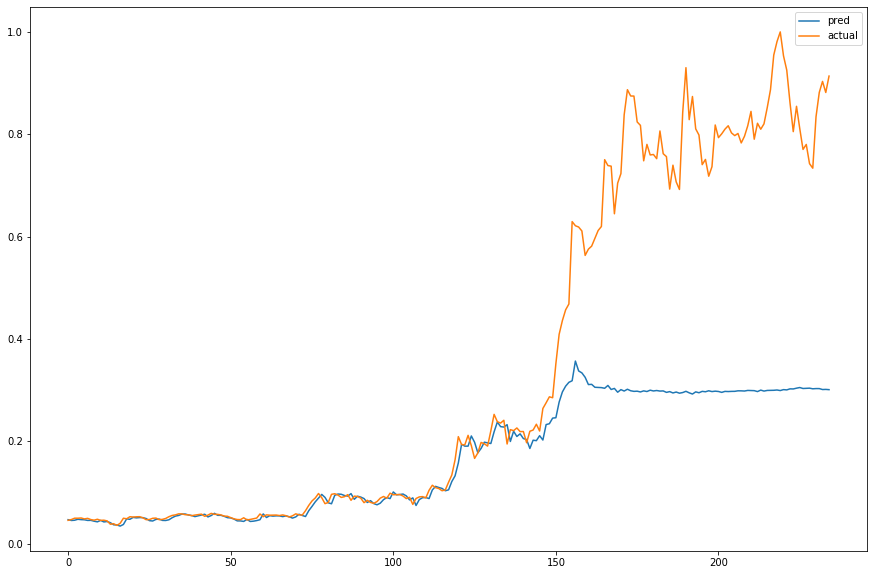

In [121]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
plt.plot(y_pred_tf_lstm, label ='pred')
plt.plot(y_test, label ='actual')
plt.legend(loc='best')

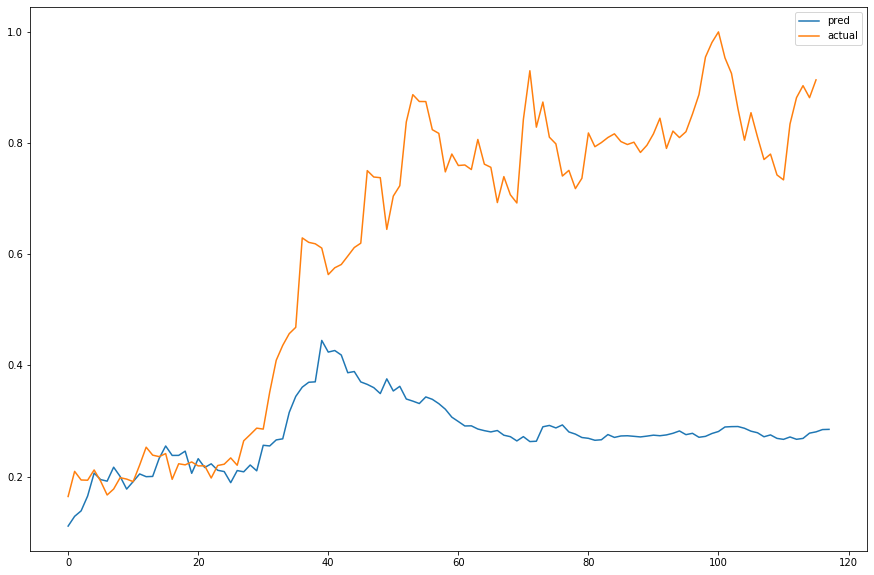

In [161]:
# smaller test size
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
plt.plot(y_pred_tf_lstm, label ='pred')
plt.plot(y_test, label ='actual')
plt.legend(loc='best')

## GRU


In [122]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model_gru = tf.keras.Sequential()
model_gru.add(tf.keras.layers.GRU(units=75, return_sequences =True,input_shape=(x_train.shape[1], x_train.shape[2])))
model_gru.add(tf.keras.layers.GRU(units=30, return_sequences =True))
model_gru.add(tf.keras.layers.GRU(units=30))
model_gru.add(tf.keras.layers.Dense(units=1))

model_gru.compile(loss='mae', optimizer='adam')
model_gru.summary()

history_gru = model_gru.fit(x_train, y_train, epochs =100, batch_size=32, validation_data =(x_test, y_test), shuffle=False)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_9 (GRU)                  (None, 9, 75)             22275     
_________________________________________________________________
gru_10 (GRU)                 (None, 9, 30)             9630      
_________________________________________________________________
gru_11 (GRU)                 (None, 30)                5580      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 31        
Total params: 37,516
Trainable params: 37,516
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
30/30 [==============================] - 2s 68ms/step - loss: 0.0353 - val_loss: 0.1632
Epoch 2/100
30/30 [==============================] - 1s 19ms/step - loss: 0.0474 - val_loss: 0.3022
Epoch 3/100
30/30 [=============================

30/30 [==============================] - 1s 17ms/step - loss: 0.0070 - val_loss: 0.0897
Epoch 74/100
30/30 [==============================] - 1s 17ms/step - loss: 0.0056 - val_loss: 0.0643
Epoch 75/100
30/30 [==============================] - 1s 17ms/step - loss: 0.0064 - val_loss: 0.0516
Epoch 76/100
30/30 [==============================] - 1s 17ms/step - loss: 0.0085 - val_loss: 0.0821
Epoch 77/100
30/30 [==============================] - 1s 17ms/step - loss: 0.0069 - val_loss: 0.0733
Epoch 78/100
30/30 [==============================] - 0s 17ms/step - loss: 0.0085 - val_loss: 0.1436
Epoch 79/100
30/30 [==============================] - 1s 18ms/step - loss: 0.0139 - val_loss: 0.0429
Epoch 80/100
30/30 [==============================] - 1s 17ms/step - loss: 0.0106 - val_loss: 0.1108
Epoch 81/100
30/30 [==============================] - 1s 17ms/step - loss: 0.0124 - val_loss: 0.1211
Epoch 82/100
30/30 [==============================] - 1s 17ms/step - loss: 0.0066 - val_loss: 0.0411
Epo

In [123]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 6))
# plt.plot(history_gru.history['loss'], label ='train_loss', color='red')
# plt.plot(history_gru.history['val_loss'], label ='test_loss', color='blue')
# plt.xlabel('epochs')
# plt.ylabel('loss')
# plt.legend(loc='best')

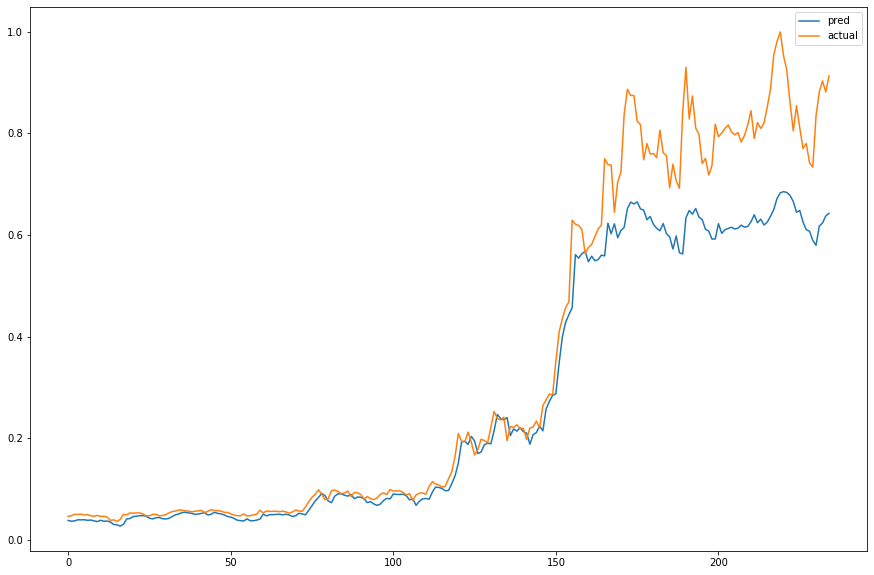

In [124]:
y_pred_tf_gru = model_gru.predict(x_test)
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
plt.plot(y_pred_tf_gru, label ='pred')
plt.plot(y_test, label ='actual')
plt.legend(loc='best')

In [112]:
# scaler.scale_
# normal_scale = 1/5.21225901e-05

# y_pred = y_pred * normal_scale
# y_test = y_test * normal_scale

# mean_y_test = y_test.mean()
# mean_y_pred = y_pred.mean()

# print(mean_y_test, mean_y_pred)
# accuracy = round((mean_y_test/mean_y_pred )*100, 2)
# accuracy

In [113]:
# X_train.shape

In [114]:
print (x_train.shape)
print (y_train.shape)
print (x_test.shape)
print (y_test.shape)

(940, 9, 22)
(940,)
(235, 9, 22)
(235,)


# Pytorch

In [74]:
input_dim = 22
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [75]:
import torch
import torch.nn as nn

x_train_gru = torch.from_numpy(x_train).type(torch.Tensor)
x_test_gru = torch.from_numpy(x_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)


In [76]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [77]:
model_pt_gru = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model_pt_gru.parameters(), lr=0.01)

In [78]:
import time
hist = np.zeros(num_epochs)

for t in range(num_epochs):
    y_train_pred = model_pt_gru(x_train_lstm)
    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "Mean Squared Error: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time

Epoch  0 Mean Squared Error:  0.011738914996385574
Epoch  1 Mean Squared Error:  0.1186441034078598
Epoch  2 Mean Squared Error:  0.010643878020346165
Epoch  3 Mean Squared Error:  0.008540120907127857
Epoch  4 Mean Squared Error:  0.02327127195894718
Epoch  5 Mean Squared Error:  0.01790269836783409
Epoch  6 Mean Squared Error:  0.006394650787115097
Epoch  7 Mean Squared Error:  0.0022007969673722982
Epoch  8 Mean Squared Error:  0.007512295618653297
Epoch  9 Mean Squared Error:  0.010606899857521057
Epoch  10 Mean Squared Error:  0.0068536982871592045
Epoch  11 Mean Squared Error:  0.00276162289083004
Epoch  12 Mean Squared Error:  0.0020889793522655964
Epoch  13 Mean Squared Error:  0.0038583900313824415
Epoch  14 Mean Squared Error:  0.005564708262681961
Epoch  15 Mean Squared Error:  0.005718960892409086
Epoch  16 Mean Squared Error:  0.004488858859986067
Epoch  17 Mean Squared Error:  0.002908644499257207
Epoch  18 Mean Squared Error:  0.0019334059907123446
Epoch  19 Mean Squared

In [79]:
y_pred_pt_gru = model_pt_gru(x_test_lstm)


In [86]:
y_pred_pt_gru.detach().numpy()

array([[0.04010077],
       [0.04025818],
       [0.04005929],
       [0.04044753],
       [0.04091543],
       [0.04078469],
       [0.04076888],
       [0.04044208],
       [0.03943535],
       [0.03940749],
       [0.03948531],
       [0.04003015],
       [0.04015073],
       [0.03999536],
       [0.03993507],
       [0.03996492],
       [0.03967515],
       [0.03927986],
       [0.03905318],
       [0.03915544],
       [0.03909396],
       [0.03925066],
       [0.03932218],
       [0.03960922],
       [0.03957857],
       [0.03957988],
       [0.03960792],
       [0.03960897],
       [0.03945012],
       [0.03932274],
       [0.03907861],
       [0.03884143],
       [0.0387166 ],
       [0.0388506 ],
       [0.03870951],
       [0.0384912 ],
       [0.0390723 ],
       [0.03929931],
       [0.03948523],
       [0.03968495],
       [0.03962307],
       [0.03940344],
       [0.0396179 ],
       [0.03906825],
       [0.03888868],
       [0.03888246],
       [0.03957085],
       [0.039

In [87]:
y_test_gru

tensor([0.0459, 0.0462, 0.0448, 0.0382, 0.0394, 0.0360, 0.0401, 0.0500, 0.0490,
        0.0530, 0.0523, 0.0529, 0.0530, 0.0508, 0.0472, 0.0475, 0.0499, 0.0503,
        0.0472, 0.0478, 0.0496, 0.0530, 0.0555, 0.0566, 0.0586, 0.0585, 0.0569,
        0.0567, 0.0549, 0.0562, 0.0572, 0.0580, 0.0537, 0.0561, 0.0595, 0.0576,
        0.0576, 0.0565, 0.0542, 0.0539, 0.0512, 0.0489, 0.0475, 0.0473, 0.0509,
        0.0467, 0.0477, 0.0490, 0.0504, 0.0584, 0.0530, 0.0566, 0.0559, 0.0562,
        0.0562, 0.0552, 0.0565, 0.0549, 0.0524, 0.0548, 0.0586, 0.0566, 0.0562,
        0.0647, 0.0750, 0.0837, 0.0896, 0.0983, 0.0900, 0.0785, 0.0808, 0.0967,
        0.0979, 0.0952, 0.0907, 0.0921, 0.0961, 0.0851, 0.0932, 0.0925, 0.0892,
        0.0804, 0.0851, 0.0809, 0.0791, 0.0826, 0.0893, 0.0925, 0.0891, 0.0989,
        0.0959, 0.0961, 0.0963, 0.0934, 0.0884, 0.0909, 0.0771, 0.0886, 0.0917,
        0.0922, 0.0897, 0.1046, 0.1144, 0.1098, 0.1080, 0.1037, 0.1053, 0.1204,
        0.1344, 0.1642, 0.2094, 0.1939, 

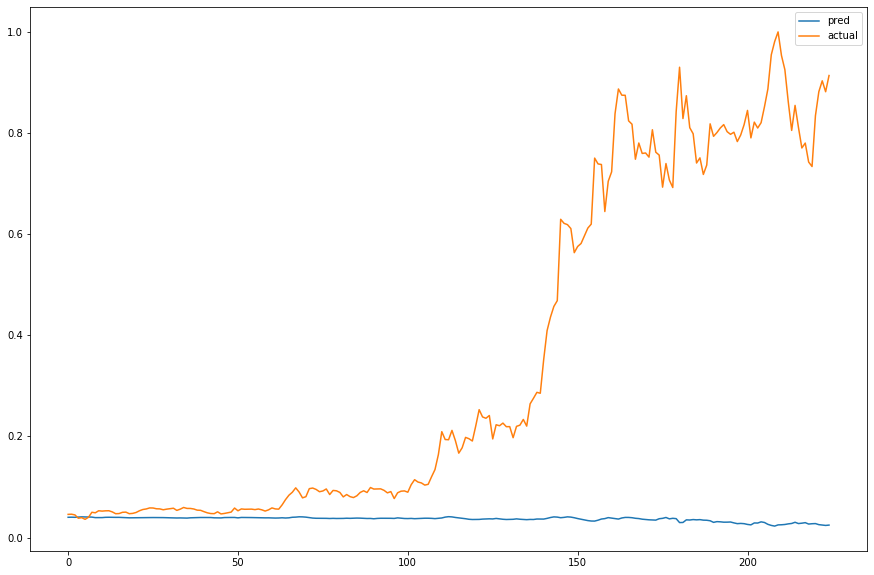

In [88]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
plt.plot(y_pred_pt_gru.detach().numpy(), label ='pred')
plt.plot(y_test_gru, label ='actual')
plt.legend(loc='best')